###### © 2020 Daniel Dimant All Rights Reserved

## In this project, we will attempt to predict the probability to rain in the next hour

## Contents of the Notebook:

<b> Part 1: Exploratory Data Analysis(EDA):</b>

1. Analysis of the features.

2. Finding any relations or trends considering multiple features.

<b>Part 2: Feature Engineering and Data Cleaning:</b>
1. Adding any few features.

2. Removing redundant features.

3. Converting features into suitable form for modeling.

<b>Part 3: Predictive Modeling</b>

1. Running Basic Algorithms.

2. Cross Validation and Hyperparameters tuning

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis(EDA)

In [99]:
df = pd.read_csv('weather_forecast.csv')

In [100]:
df.head()

,time,ghi,dni,dhi,air_temperature,relative_humidity,wind_speed,wind_speed_of_gust,wind_from_direction_st_dev,wind_from_direction,barometric_pressure,rain,sensor_cleaning,comments
0,01/07/18 00:01,0.0,0.0,0.0,28.1,89.3,1.2,1.6,0.0,82.5,982.9,0.0,0,NaN
1,01/07/18 00:02,0.0,0.0,0.0,28.1,89.3,0.9,1.6,0.0,82.5,982.8,0.0,0,NaN
2,01/07/18 00:03,0.0,0.0,0.0,28.1,89.4,0.9,1.3,0.0,82.5,982.9,0.0,0,NaN
3,01/07/18 00:04,0.0,0.0,0.0,28.1,89.3,1.1,1.6,0.0,82.6,982.8,0.0,0,NaN
4,01/07/18 00:05,0.0,0.0,0.0,28.1,89.6,1.2,1.8,0.1,82.6,982.9,0.0,0,NaN


In [4]:
# Drop comments coloumn
df.drop('comments', axis=1, inplace=True)

In [5]:
# Convert time column from string to datetime type
df.time = pd.to_datetime(df.time)

In [6]:
# Check if there are missing values 
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [7]:
missing_data(df)

,time,ghi,dni,dhi,air_temperature,relative_humidity,wind_speed,wind_speed_of_gust,wind_from_direction_st_dev,wind_from_direction,barometric_pressure,rain,sensor_cleaning
Total,0,0,0,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0
Types,datetime64[ns],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64


There aren't any missing values.

Let's look at some statistics of each column

In [8]:
df.describe()

,ghi,dni,dhi,air_temperature,relative_humidity,wind_speed,wind_speed_of_gust,wind_from_direction_st_dev,wind_from_direction,barometric_pressure,rain,sensor_cleaning
count,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000,614880.000000
mean,198.021850,145.374776,97.742826,25.010465,74.606286,1.515790,2.141400,5.461113,135.784080,989.277401,0.002521,0.000564
std,284.862307,239.416905,133.248368,7.503255,21.787799,1.377934,1.785418,6.806879,113.321473,7.186049,0.046961,0.023749
min,0.000000,0.000000,0.000000,2.800000,8.700000,0.000000,0.000000,0.000000,0.000000,974.500000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,19.800000,58.500000,0.200000,1.100000,0.000000,34.000000,982.800000,0.000000,0.000000
50%,2.500000,0.000000,2.200000,26.800000,81.150000,1.400000,1.800000,2.400000,117.200000,988.500000,0.000000,0.000000
75%,360.100000,256.700000,182.100000,30.200000,93.500000,2.200000,2.900000,9.800000,247.400000,995.900000,0.000000,0.000000
max,1395.000000,971.000000,1015.000000,42.700000,100.000000,19.500000,24.600000,98.300000,360.000000,1005.400000,18.500000,1.000000


We can see that sensor_cleaning values are mostly 0 so we will drop this column

In [9]:
df.drop('sensor_cleaning', axis=1, inplace=True)

Let's look at the distribution of rain column

In [10]:
df.rain.value_counts()

0.0     607877
0.1       4398
0.2       1009
0.3        507
0.4        326
0.5        227
0.6        127
0.7        114
0.8         66
0.9         52
1.0         40
1.1         36
1.2         27
1.3         26
1.4         14
1.5          8
1.8          7
1.6          6
2.0          4
1.9          3
1.7          2
2.2          1
18.5         1
17.3         1
2.5          1
Name: rain, dtype: int64

## Correlation Between The Features

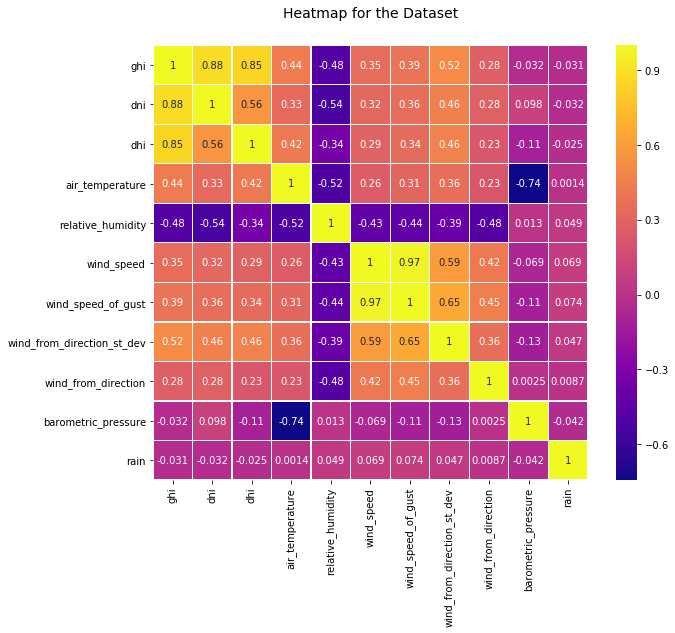

In [11]:
# making a heat map
plt.figure(figsize=(10,8))
colormap = plt.cm.plasma

sns.heatmap(df.corr(), linewidths=0.2,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

plt.title('Heatmap for the Dataset', y=1.05, size=14)
plt.show()

We can see there are some highly correlated features, <b>dhi</b> and <b>dni</b> are highly correlated with <b>gni</b>; we will only keep <b>gni</b>
In addition, <b>wind_speed_of_gust</b> is highly correlated: 0.97! with <b>wind_speed</b>. Because <b>wind_speed_of_gust</b> has a higher correlation with rain, we will drop <b>wind_speed</b>. We will also drop <b>wind_from_direction_st_dev</b> for the same reason.


In [12]:
df.drop(['dni','dhi','wind_speed','wind_from_direction_st_dev'], axis=1, inplace=True)

In [13]:
df.head()

,time,ghi,air_temperature,relative_humidity,wind_speed_of_gust,wind_from_direction,barometric_pressure,rain
0,2018-01-07 00:01:00,0.0,28.1,89.3,1.6,82.5,982.9,0.0
1,2018-01-07 00:02:00,0.0,28.1,89.3,1.6,82.5,982.8,0.0
2,2018-01-07 00:03:00,0.0,28.1,89.4,1.3,82.5,982.9,0.0
3,2018-01-07 00:04:00,0.0,28.1,89.3,1.6,82.6,982.8,0.0
4,2018-01-07 00:05:00,0.0,28.1,89.6,1.8,82.6,982.9,0.0


Let's look how the features behave at the minutes following the rain

In [14]:
# Find rows where rain value changes
rain_list = df.rain.tolist()
rows_rain_change = [i for i in range(0,len(rain_list)) if rain_list[i]!=rain_list[i-1] ]

In [15]:
rows_rain_change[0:70]

[433,
 434,
 437,
 438,
 444,
 445,
 590,
 591,
 597,
 599,
 600,
 601,
 604,
 605,
 607,
 608,
 609,
 610,
 611,
 615,
 617,
 618,
 619,
 621,
 622,
 623,
 624,
 625,
 626,
 629,
 630,
 631,
 633,
 634,
 635,
 636,
 637,
 639,
 640,
 641,
 642,
 643,
 644,
 645,
 646,
 647,
 648,
 649,
 650,
 652,
 653,
 656,
 657,
 659,
 661,
 662,
 663,
 665,
 666,
 749,
 750,
 751,
 752,
 759,
 760,
 1124,
 1125,
 1126,
 1127,
 1128]

In [16]:
df.iloc[433:446,-1]

433    0.1
434    0.0
435    0.0
436    0.0
437    0.1
438    0.0
439    0.0
440    0.0
441    0.0
442    0.0
443    0.0
444    0.1
445    0.0
Name: rain, dtype: float64

As we can see, after the first 433 minutes, it started raining, and then it stopped a minute after.

Let's find a series with stronger rain

In [17]:
df[df['rain'] == 1.4]

,time,ghi,air_temperature,relative_humidity,wind_speed_of_gust,wind_from_direction,barometric_pressure,rain
1129,2018-01-07 18:50:00,0.0,27.6,96.0,3.1,139.4,980.6,1.4
1680,2018-02-07 04:01:00,0.0,25.6,100.0,5.4,95.4,979.3,1.4
1755,2018-02-07 05:16:00,0.0,25.3,100.0,4.9,130.6,979.4,1.4
1773,2018-02-07 05:34:00,0.0,25.3,100.0,2.1,79.8,979.4,1.4
81649,2018-08-26 16:50:00,16.0,25.6,98.0,6.2,101.3,979.6,1.4
81650,2018-08-26 16:51:00,19.0,25.5,98.4,5.4,96.0,979.6,1.4
104694,2018-11-09 16:55:00,32.0,28.0,91.1,6.2,283.6,986.6,1.4
104695,2018-11-09 16:56:00,42.0,27.6,92.6,5.9,328.3,986.6,1.4
104697,2018-11-09 16:58:00,66.0,27.0,93.1,6.4,330.2,986.6,1.4
104698,2018-11-09 16:59:00,94.0,26.9,93.2,4.7,341.5,986.7,1.4


In [18]:
# 30 MINUTES
df.iloc[1098:1129,-1]

1098    0.0
1099    0.0
1100    0.0
1101    0.0
1102    0.0
1103    0.0
1104    0.0
1105    0.0
1106    0.0
1107    0.0
1108    0.0
1109    0.0
1110    0.0
1111    0.0
1112    0.0
1113    0.0
1114    0.0
1115    0.0
1116    0.0
1117    0.0
1118    0.0
1119    0.0
1120    0.0
1121    0.0
1122    0.0
1123    0.0
1124    0.4
1125    0.5
1126    0.9
1127    0.7
1128    1.0
Name: rain, dtype: float64

In [19]:
df.iloc[81620:81651,-1]

81620    0.0
81621    0.0
81622    0.0
81623    0.0
81624    0.0
81625    0.0
81626    0.0
81627    0.3
81628    0.4
81629    0.5
81630    0.9
81631    0.8
81632    0.8
81633    0.7
81634    0.2
81635    0.9
81636    0.4
81637    0.1
81638    0.1
81639    0.0
81640    0.0
81641    0.2
81642    0.0
81643    0.1
81644    0.1
81645    0.2
81646    0.2
81647    0.3
81648    1.0
81649    1.4
81650    1.4
Name: rain, dtype: float64

In [20]:
# Lets take two different series following rain
df1 = df.iloc[1098:1129,:].copy()
df2 = df.iloc[81620:81651,:].copy()
df1.set_index('time', inplace=True) 
df2.set_index('time', inplace=True) 

In [21]:
df1.tail(10)

,ghi,air_temperature,relative_humidity,wind_speed_of_gust,wind_from_direction,barometric_pressure,rain
time,,,,,,,
2018-01-07 18:40:00,1.0,28.1,92.6,4.1,135.8,980.3,0.0
2018-01-07 18:41:00,1.0,28.1,92.7,3.9,134.3,980.3,0.0
2018-01-07 18:42:00,1.0,28.1,92.7,3.6,139.2,980.4,0.0
2018-01-07 18:43:00,0.0,28.1,92.9,3.6,143.8,980.4,0.0
2018-01-07 18:44:00,0.0,28.1,93.0,4.7,151.8,980.4,0.0
2018-01-07 18:45:00,0.0,28.1,93.4,3.6,144.7,980.5,0.4
2018-01-07 18:46:00,0.0,28.0,93.7,2.9,137.2,980.5,0.5
2018-01-07 18:47:00,0.0,27.9,94.1,3.6,137.9,980.4,0.9
2018-01-07 18:48:00,0.0,27.8,94.9,3.1,131.2,980.5,0.7


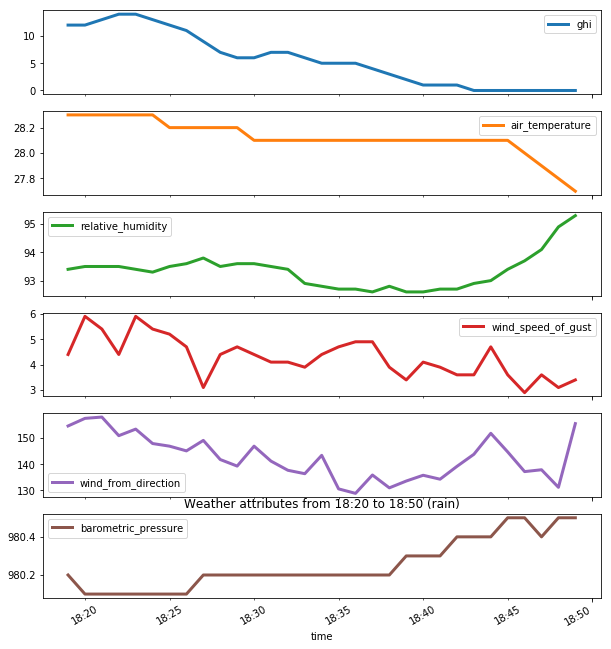

In [22]:
df1.iloc[:,:-1].plot(subplots=True, figsize=(10,12),linewidth=3)
plt.title('Weather attributes from 18:20 to 18:50 (rain)')
plt.show()

We can see that <b>ghi</b> was 0 & <b>relative humidity</b> started to go up.
<b>air temperature</b> went down and <b>barometric pressure </b> went up

Let's take a look at some statistics during this period of time

In [23]:
df1.iloc[:,:-1].describe()

,ghi,air_temperature,relative_humidity,wind_speed_of_gust,wind_from_direction,barometric_pressure
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,5.677419,28.122581,93.338710,4.280645,142.629032,980.251613
std,4.921972,0.138347,0.630702,0.790957,8.437543,0.133843
min,0.000000,27.700000,92.600000,2.900000,128.900000,980.100000
25%,1.000000,28.100000,92.800000,3.600000,136.150000,980.200000
50%,5.000000,28.100000,93.400000,4.400000,141.800000,980.200000
75%,10.000000,28.200000,93.550000,4.700000,148.500000,980.350000
max,14.000000,28.300000,95.300000,5.900000,158.000000,980.500000


It started raining when ghi got to 0, air_temperature to 27.7, relative_humidity 94 & barometric_pressure was 980.5

Let's look at the second series

In [24]:
df2.tail(10)

,ghi,air_temperature,relative_humidity,wind_speed_of_gust,wind_from_direction,barometric_pressure,rain
time,,,,,,,
2018-08-26 16:42:00,5.0,27.8,92.5,12.3,96.4,979.2,0.2
2018-08-26 16:43:00,4.0,27.1,92.5,9.5,108.4,979.3,0.0
2018-08-26 16:44:00,5.0,26.6,94.2,8.5,114.1,979.3,0.1
2018-08-26 16:45:00,6.0,26.2,94.3,9.2,113.5,979.3,0.1
2018-08-26 16:46:00,9.0,26.0,95.9,7.2,119.7,979.4,0.2
2018-08-26 16:47:00,12.0,25.8,97.0,6.2,103.7,979.5,0.2
2018-08-26 16:48:00,14.0,25.8,97.9,7.2,107.0,979.5,0.3
2018-08-26 16:49:00,14.0,25.7,98.2,7.7,97.9,979.6,1.0
2018-08-26 16:50:00,16.0,25.6,98.0,6.2,101.3,979.6,1.4


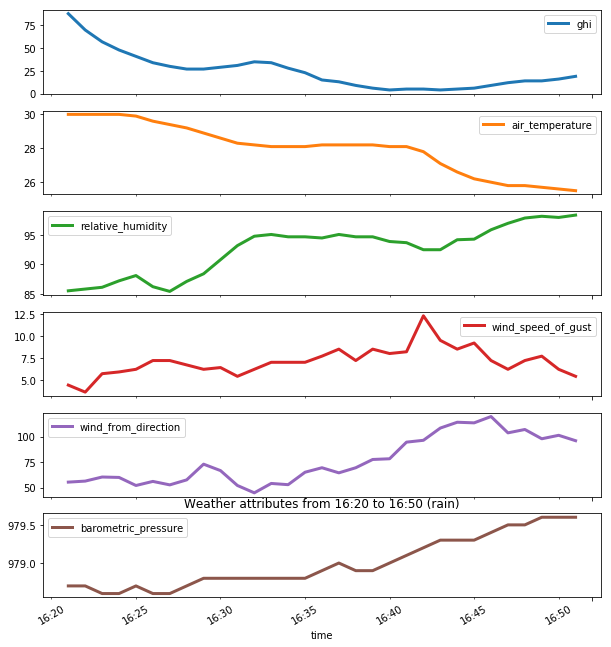

In [25]:
df2.iloc[:,:-1].plot(subplots=True, figsize=(10,12),linewidth=3)
plt.title('Weather attributes from 16:20 to 16:50 (rain)')
plt.show()

In [26]:
df2.iloc[:,:-1].describe()

,ghi,air_temperature,relative_humidity,wind_speed_of_gust,wind_from_direction,barometric_pressure
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,24.451613,27.983871,92.535484,7.083871,76.500000,978.996774
std,20.200394,1.461756,4.210823,1.626058,23.070009,0.335146
min,4.000000,25.500000,85.400000,3.600000,44.900000,978.600000
25%,9.000000,26.850000,88.250000,6.200000,56.250000,978.750000
50%,19.000000,28.200000,94.200000,7.000000,69.500000,978.900000
75%,32.500000,29.050000,94.950000,7.850000,97.150000,979.300000
max,88.000000,30.000000,98.400000,12.300000,119.700000,979.600000


In [27]:
# Make a copy of original dataframe
df_copy = df.copy()

In [28]:
df_copy.head()

,time,ghi,air_temperature,relative_humidity,wind_speed_of_gust,wind_from_direction,barometric_pressure,rain
0,2018-01-07 00:01:00,0.0,28.1,89.3,1.6,82.5,982.9,0.0
1,2018-01-07 00:02:00,0.0,28.1,89.3,1.6,82.5,982.8,0.0
2,2018-01-07 00:03:00,0.0,28.1,89.4,1.3,82.5,982.9,0.0
3,2018-01-07 00:04:00,0.0,28.1,89.3,1.6,82.6,982.8,0.0
4,2018-01-07 00:05:00,0.0,28.1,89.6,1.8,82.6,982.9,0.0


In [29]:
df.shape

(614880, 8)

In [30]:
# Set datetime column as index
df_copy.set_index('time', inplace=True)

In [31]:
# Create new columns; for each column - min,max and mean values (for rain we will keep mean value)
params = {'ghi': {'min_ghi':np.min,'max_ghi':np.max,'mean_ghi':np.mean},
     'air_temperature': {'min_air_temperature':np.min,'max_air_temperature':np.max,'mean_air_temperature':np.mean},
     'relative_humidity': {'min_relative_humidity':np.min,'max_relative_humidity':np.max,'mean_relative_humidity':np.mean},
     'wind_speed_of_gust': {'min_wind_speed_of_gust':np.min,'max_wind_speed_of_gust':np.max,'mean_wind_speed_of_gust':np.mean},
     'wind_from_direction': {'min_wind_from_direction':np.min,'max_wind_from_direction':np.max,'mean_wind_from_direction':np.mean},
     'barometric_pressure': {'min_barometric_pressure':np.min,'max_barometric_pressure':np.max,'mean_barometric_pressure':np.mean},
     'rain': {'rain':np.mean}
    }

In [32]:
# Convert to hourly data
df_copy = df_copy.resample('H', how=params)

In [33]:
df_copy.head()

ghi                      air_temperature  \
                    min_ghi max_ghi mean_ghi min_air_temperature   
time                                                               
2018-01-07 00:00:00     0.0     0.0      0.0                27.9   
2018-01-07 01:00:00     0.0     0.0      0.0                27.8   
2018-01-07 02:00:00     0.0     0.0      0.0                27.8   
2018-01-07 03:00:00     0.0     0.0      0.0                27.6   
2018-01-07 04:00:00     0.0     0.0      0.0                27.5   

                                                              \
                    max_air_temperature mean_air_temperature   
time                                                           
2018-01-07 00:00:00                28.1            28.061017   
2018-01-07 01:00:00                27.9            27.875000   
2018-01-07 02:00:00                27.9            27.873333   
2018-01-07 03:00:00                27.9            27.735000   
2018-01-07 04:00:00                27.8            27.658333   

                        relative_humidity                        \
                    min_relative_humidity max_relative_humidity   
time                                                              
2018-01-07 00:00:00                  88.7                  90.4   
2018-01-07 01:00:00                  89.4                  90.4   
2018-01-07 02:00:00                  89.1                  90.9   
2018-01-07 03:00:00                  90.2                  92.3   
2018-01-07 04:00:00                  91.7                  94.4   

                                               wind_speed_of_gust  \
                    mean_relative_humidity min_wind_speed_of_gust   
time                                                                
2018-01-07 00:00:00              89.364407                    1.3   
2018-01-07 01:00:00              89.790000                    0.4   
2018-01-07 02:00:00              89.916667                    0.0   
2018-01-07 03:00:00              91.665000                    0.0   
2018-01-07 04:00:00              92.973333                    0.0   

                                                                    \
                    max_wind_speed_of_gust mean_wind_speed_of_gust   
time                                                                 
2018-01-07 00:00:00                    3.6                2.615254   
2018-01-07 01:00:00                    3.6                2.318333   
2018-01-07 02:00:00                    2.9                1.378333   
2018-01-07 03:00:00                    2.1                0.695000   
2018-01-07 04:00:00                    1.8                0.608333   

                        wind_from_direction                          \
                    min_wind_from_direction max_wind_from_direction   
time                                                                  
2018-01-07 00:00:00                    35.9                    92.6   
2018-01-07 01:00:00                    57.2                    98.1   
2018-01-07 02:00:00                     0.0                   218.5   
2018-01-07 03:00:00                     0.0                   263.6   
2018-01-07 04:00:00                     0.0                   263.9   

                                                 barometric_pressure  \
                    mean_wind_from_direction min_barometric_pressure   
time                                                                   
2018-01-07 00:00:00                65.345763                   982.3   
2018-01-07 01:00:00                72.023333                   981.7   
2018-01-07 02:00:00               117.958333                   981.1   
2018-01-07 03:00:00               116.876667                   980.7   
2018-01-07 04:00:00                61.930000                   980.4   

                                                                     rain  
                    max_barometric_pressure mean_barometric_pressure rain  
time             

In [34]:
# Drop top level
df_copy.columns = df_copy.columns.droplevel(0)

In [35]:
df_copy.head()

,min_ghi,max_ghi,mean_ghi,min_air_temperature,max_air_temperature,mean_air_temperature,min_relative_humidity,max_relative_humidity,mean_relative_humidity,min_wind_speed_of_gust,max_wind_speed_of_gust,mean_wind_speed_of_gust,min_wind_from_direction,max_wind_from_direction,mean_wind_from_direction,min_barometric_pressure,max_barometric_pressure,mean_barometric_pressure,rain
time,,,,,,,,,,,,,,,,,,,
2018-01-07 00:00:00,0.0,0.0,0.0,27.9,28.1,28.061017,88.7,90.4,89.364407,1.3,3.6,2.615254,35.9,92.6,65.345763,982.3,982.9,982.623729,0.0
2018-01-07 01:00:00,0.0,0.0,0.0,27.8,27.9,27.875000,89.4,90.4,89.790000,0.4,3.6,2.318333,57.2,98.1,72.023333,981.7,982.3,982.025000,0.0
2018-01-07 02:00:00,0.0,0.0,0.0,27.8,27.9,27.873333,89.1,90.9,89.916667,0.0,2.9,1.378333,0.0,218.5,117.958333,981.1,981.7,981.531667,0.0
2018-01-07 03:00:00,0.0,0.0,0.0,27.6,27.9,27.735000,90.2,92.3,91.665000,0.0,2.1,0.695000,0.0,263.6,116.876667,980.7,981.1,980.873333,0.0
2018-01-07 04:00:00,0.0,0.0,0.0,27.5,27.8,27.658333,91.7,94.4,92.973333,0.0,1.8,0.608333,0.0,263.9,61.930000,980.4,980.7,980.555000,0.0


In [36]:
# Map rain > 0 to 1, else 0
df_copy['rain'] = df_copy['rain'].apply(lambda x:1 if x > 0 else 0)

In [37]:
df_copy['rain'].value_counts()

0    16133
1      691
Name: rain, dtype: int64

Let's look at rain distribution for each month

In [38]:
df_copy['datetime'] = df_copy.index

In [39]:
df_copy['month'] = df_copy['datetime'].apply(lambda x: x.month)

Text(0.5,1,'Rain throughout Months')

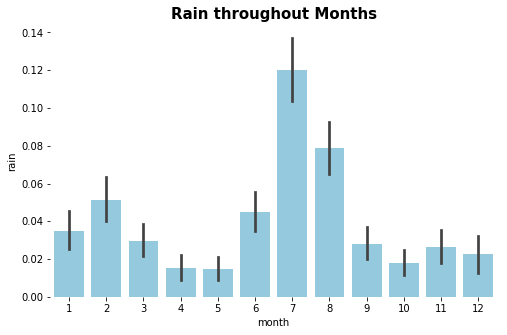

In [40]:
# plotting Rainfall per Month
plt.figure(figsize=(8,5))
sns.barplot(x = 'month', y='rain', data=df_copy, color = 'skyblue')
plt.box(False)
plt.title ('Rain throughout Months', fontweight="bold",fontsize=15)

Most of the rainy days were during July & August

In [45]:
df_copy.drop(['datetime'], axis=1, inplace=True)

In [46]:
df_copy.shape

(16824, 20)

## Create a new column that will be used for prediction

##### For each row (hour), check preceding row rain value and assign to column 'rain_next_hour'

In [47]:
df_copy['rain_next_hour'] = df_copy['rain'].shift(-1)

In [48]:
df_copy.tail()

,min_ghi,max_ghi,mean_ghi,min_air_temperature,max_air_temperature,mean_air_temperature,min_relative_humidity,max_relative_humidity,mean_relative_humidity,min_wind_speed_of_gust,...,mean_wind_speed_of_gust,min_wind_from_direction,max_wind_from_direction,mean_wind_from_direction,min_barometric_pressure,max_barometric_pressure,mean_barometric_pressure,rain,month,rain_next_hour
time,,,,,,,,,,,,,,,,,,,,,
2019-12-08 19:00:00,0.0,10.8,0.588333,32.2,32.7,32.425000,81.7,84.8,83.408333,0.0,...,0.436667,0.0,298.9,114.258333,979.2,979.7,979.461667,0,12,0.0
2019-12-08 20:00:00,0.0,0.0,0.000000,31.5,32.2,31.858333,84.9,87.6,86.418333,0.0,...,0.845000,0.0,268.3,173.698333,979.7,980.4,980.070000,0,12,0.0
2019-12-08 21:00:00,0.0,0.0,0.000000,31.1,31.5,31.240000,87.6,88.4,88.126667,0.0,...,1.178333,0.0,279.5,226.333333,980.5,981.8,981.220000,0,12,0.0
2019-12-08 22:00:00,0.0,0.0,0.000000,30.8,31.1,30.941667,87.9,88.4,88.163333,0.0,...,1.460000,0.0,311.1,285.695000,981.6,981.8,981.721667,0,12,0.0
2019-12-08 23:00:00,0.0,0.0,0.000000,30.5,30.8,30.638333,88.0,89.6,88.615000,0.0,...,1.325000,0.0,359.6,211.495000,981.3,981.6,981.426667,0,12,NaN


In [49]:
# Drop last row, and 'rain' column
df_copy.dropna(inplace=True)
df_copy.drop(['rain'], axis=1, inplace=True)

In [50]:
df_copy['rain_next_hour'].value_counts()

0.0    9559
1.0     689
Name: rain_next_hour, dtype: int64

# Define Functions

In [51]:
# ROC curve
def plot_roc(fpr,tpr,roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [52]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall','f1']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

# Prepare Dataset

In [56]:
# Split to features and target
y = df_copy.rain_next_hour.values
X = df_copy.drop('rain_next_hour', axis=1).values

### Standard Scaler

In [58]:
# Normalization
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Train test split

In [119]:
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = random_state)

# Predictive Modeling

## Logistic Regression

In [60]:
# Find best hyperparameters (accuracy)
log_clf = LogisticRegression(random_state = random_state)

weights = np.linspace(0.05, 0.95, 20)

param_grid = {
            'penalty' : ['l2','l1'],  
            'C' : [0.001, 0.01, 0.1],
            'class_weight': [{0: x, 1: 1.0-x} for x in weights]
            }

cv = StratifiedKFold(n_splits=5)

CV_log_clf = GridSearchCV(estimator = log_clf,cv = cv ,param_grid = param_grid , scoring = 'f1', verbose = 1, n_jobs = -1)
CV_log_clf.fit(X_train, y_train)

best_parameters = CV_log_clf.best_params_
print('The best parameters for using this model is', best_parameters)


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s


The best parameters for using this model is {'C': 0.1, 'class_weight': {0: 0.19210526315789472, 1: 0.8078947368421052}, 'penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished


              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      1916
         1.0       0.45      0.70      0.55       134

    accuracy                           0.92      2050
   macro avg       0.71      0.82      0.75      2050
weighted avg       0.94      0.92      0.93      2050



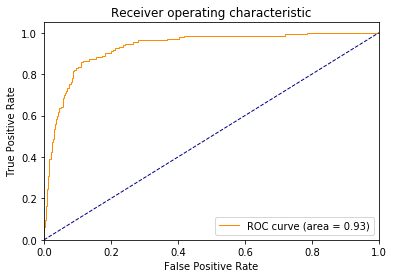

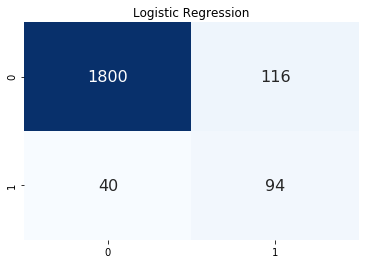

In [61]:
#Log with best hyperparameters
CV_log_clf = LogisticRegression(**best_parameters)
CV_log_clf.fit(X_train, y_train)
y_pred = CV_log_clf.predict(X_test)
y_score = CV_log_clf.predict_proba(X_test)

#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_lr = confusion_matrix(y_test, y_pred)
plt.title("Logistic Regression")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

# RFE : Recursive features elimination (19 features => 9 features)

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96      1916
         1.0       0.45      0.70      0.55       134

    accuracy                           0.92      2050
   macro avg       0.71      0.82      0.75      2050
weighted avg       0.94      0.92      0.93      2050



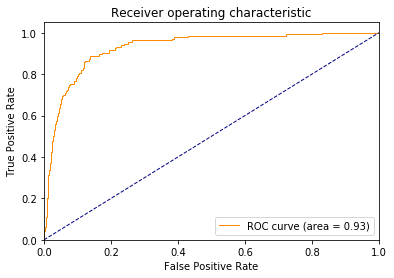

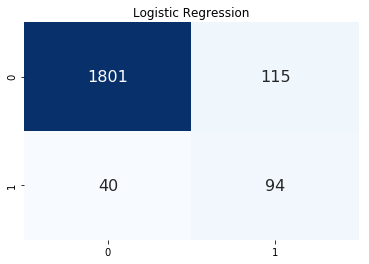

In [64]:
#Logistic regression with RFE
log_clf = LogisticRegression(**best_parameters)

selector = RFE(log_clf)
selector = selector.fit(X_train, y_train)

y_pred = selector.predict(X_test)
y_score = selector.predict_proba(X_test)


#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_lr = confusion_matrix(y_test, y_pred)
plt.title("Logistic Regression")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

In [65]:
# support and ranking RFE
print(selector.support_)
print(selector.ranking_)

[ True  True False False False False  True  True  True False  True False
 False  True False  True False  True False]
[ 1  1  2  6  9 11  1  1  1  7  1  8  3  1 10  1  5  1  4]


In [66]:
# Cross val Log 
cross_log = cross_val_metrics(CV_log_clf)

[accuracy] : 0.90720 (+/- 0.06121)
[precision] : 0.50587 (+/- 0.20224)
[recall] : 0.56598 (+/- 0.14361)
[f1] : 0.48904 (+/- 0.12360)


In [67]:
# Cross val Log with RFE
cross_selector = cross_val_metrics(selector)

[accuracy] : 0.90506 (+/- 0.06075)
[precision] : 0.51050 (+/- 0.21073)
[recall] : 0.56597 (+/- 0.14918)
[f1] : 0.48079 (+/- 0.12357)


## Linear Support Vector Machine(linear-SVM)

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97      1916
         1.0       0.00      0.00      0.00       134

    accuracy                           0.93      2050
   macro avg       0.47      0.50      0.48      2050
weighted avg       0.87      0.93      0.90      2050



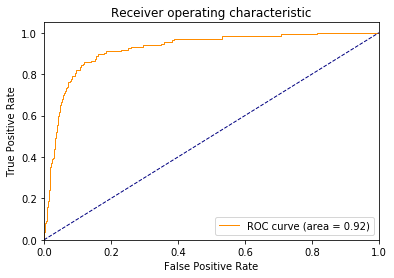

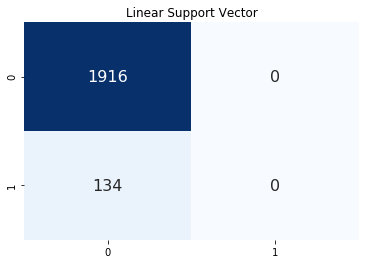

In [68]:
lsvm = svm.SVC(kernel='linear',C=0.1,gamma=0.1, probability=True)

lsvm.fit(X_train, y_train)
y_pred = lsvm.predict(X_test)
y_score = lsvm.predict_proba(X_test)

#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_lsvm = confusion_matrix(y_test, y_pred)
plt.title("Linear Support Vector")
sns.heatmap(cm_lsvm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

## Radial Support Vector Machines(rbf-SVM)

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1916
         1.0       0.68      0.25      0.37       134

    accuracy                           0.94      2050
   macro avg       0.81      0.62      0.67      2050
weighted avg       0.93      0.94      0.93      2050



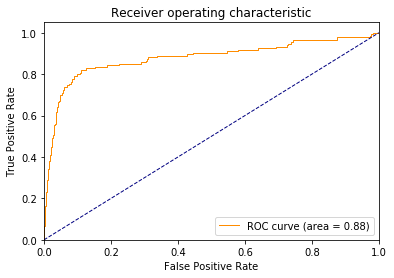

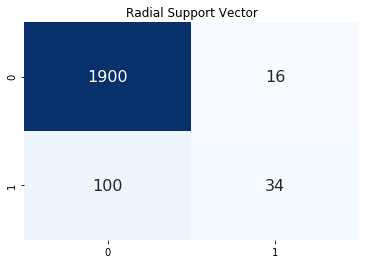

In [69]:
rsvm = svm.SVC(kernel='rbf',C=1,gamma=0.1, probability=True)

rsvm.fit(X_train, y_train)
y_pred = rsvm.predict(X_test)
y_score = rsvm.predict_proba(X_test)

#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_rsvm = confusion_matrix(y_test, y_pred)
plt.title("Radial Support Vector")
sns.heatmap(cm_rsvm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

## Decision Tree

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      1916
         1.0       0.40      0.48      0.43       134

    accuracy                           0.92      2050
   macro avg       0.68      0.71      0.70      2050
weighted avg       0.93      0.92      0.92      2050



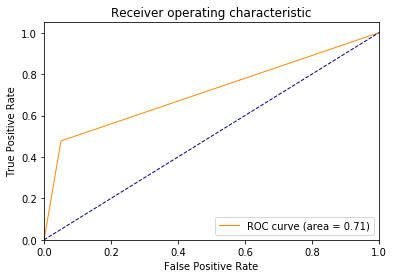

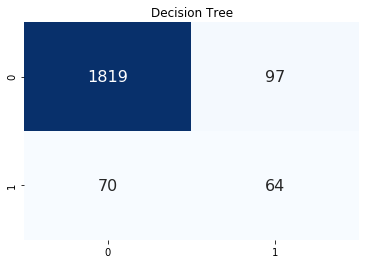

In [70]:
dt = DecisionTreeClassifier(random_state=42)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_score = dt.predict_proba(X_test)

#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_dt = confusion_matrix(y_test, y_pred)
plt.title("Decision Tree")
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

## K-Nearest Neighbours(KNN)

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1916
         1.0       0.67      0.40      0.50       134

    accuracy                           0.95      2050
   macro avg       0.81      0.69      0.74      2050
weighted avg       0.94      0.95      0.94      2050



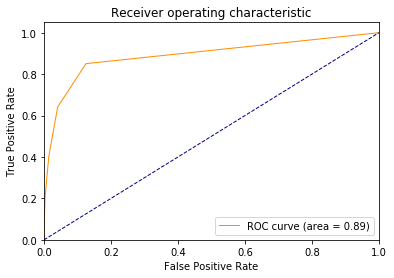

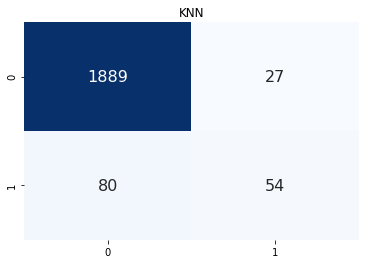

In [71]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_score = knn.predict_proba(X_test)


#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_knn = confusion_matrix(y_test, y_pred)
plt.title("KNN")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

## Random Forest

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1916
         1.0       0.70      0.44      0.54       134

    accuracy                           0.95      2050
   macro avg       0.83      0.71      0.76      2050
weighted avg       0.94      0.95      0.95      2050



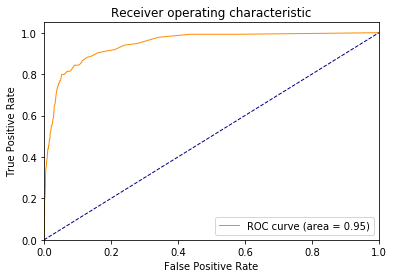

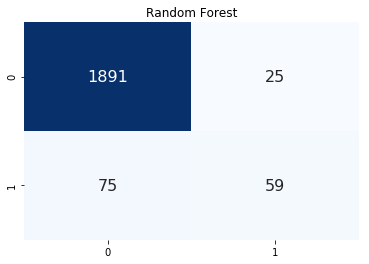

In [72]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)


#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_rfc = confusion_matrix(y_test, y_pred)
plt.title("Random Forest")
sns.heatmap(cm_rfc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

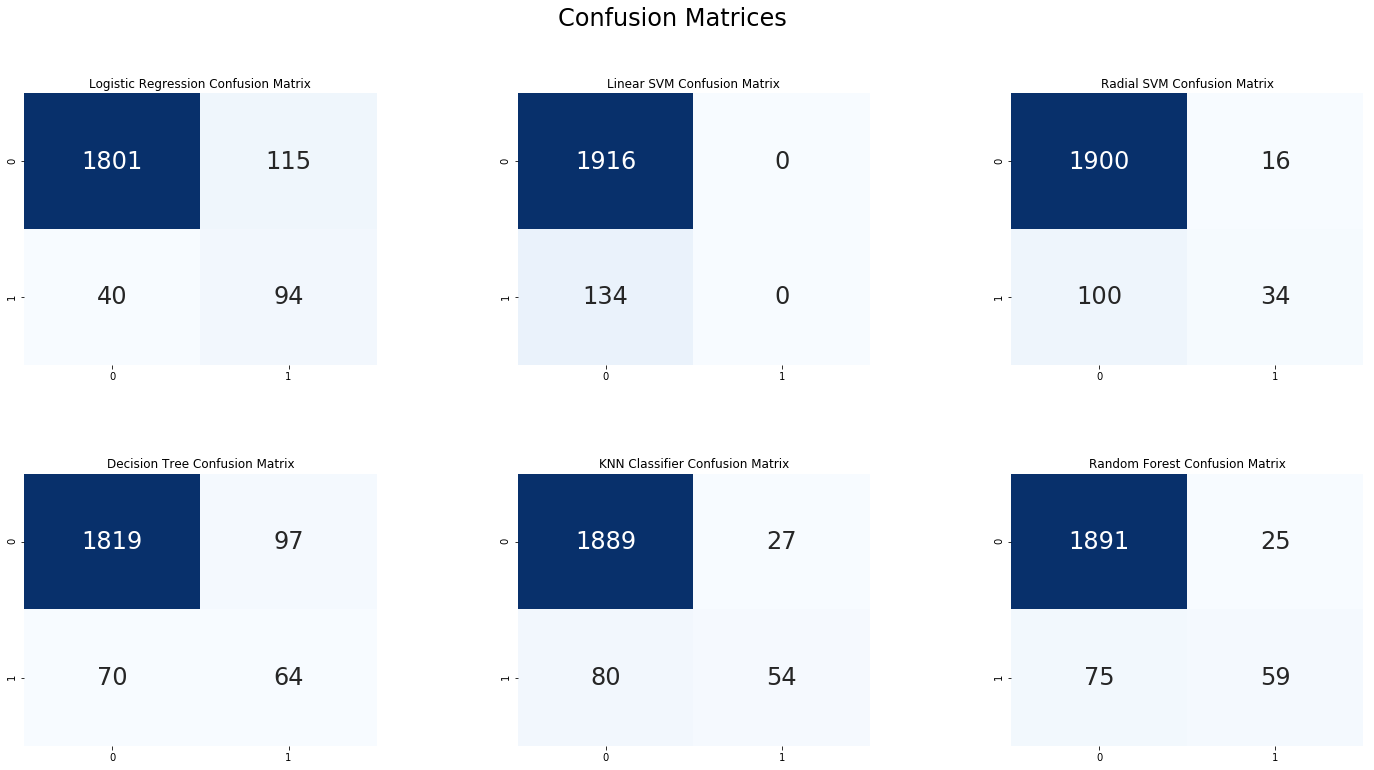

In [73]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrices",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Logistic Regression Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,2)
plt.title("Linear SVM Confusion Matrix")
sns.heatmap(cm_lsvm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,3)
plt.title("Radial SVM Confusion Matrix")
sns.heatmap(cm_rsvm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,4)
plt.title("Decision Tree Confusion Matrix")
sns.heatmap(cm_dt,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,5)
plt.title("KNN Classifier Confusion Matrix")
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.subplot(2,3,6)
plt.title("Random Forest Confusion Matrix")
sns.heatmap(cm_rfc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# Random Forest hyperparameters tuning

In [120]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

clf = RandomForestClassifier(random_state = random_state)

f1_scorer = make_scorer(f1_score, pos_label=1)


param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_depth' : [4,5,6,7,8,9],
    'class_weight': [None, 'balanced']   
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= cv, scoring=f1_scorer)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                         

In [121]:
print(CV_rfc.best_params_)

{'class_weight': 'balanced', 'max_depth': 9, 'n_estimators': 100}


              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95       957
         1.0       0.40      0.75      0.53        68

    accuracy                           0.91      1025
   macro avg       0.69      0.84      0.74      1025
weighted avg       0.94      0.91      0.92      1025



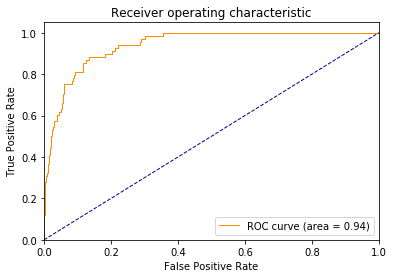

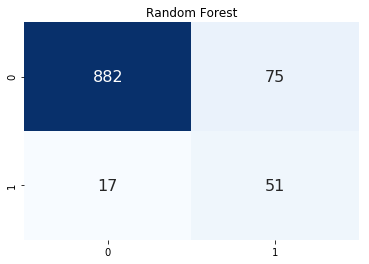

In [122]:
rfc_tuned = RandomForestClassifier(**CV_rfc.best_params_)
rfc_tuned.fit(X_train, y_train)
y_pred = rfc_tuned.predict(X_test)
y_score = rfc_tuned.predict_proba(X_test)


#Classification report
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])
roc_auc = auc(fpr, tpr)
plot_roc(fpr,tpr,roc_auc)

# Confusion metrics
cm_rfc = confusion_matrix(y_test, y_pred)
plt.title("Random Forest")
sns.heatmap(cm_rfc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 16})

### The results are pretty satisfying
#### Let's use this model and save both the model and the scaler

In [84]:
import pickle
# pickle the model file
with open('model', 'wb') as file:
    pickle.dump(rfc_tuned, file)

In [85]:
# pickle the scaler file
with open('scaler','wb') as file:
    pickle.dump(scaler, file)